# Construction of index from firm characteristics

This notebook builds a column index for each stock at a given date based on its firm's monthly characteristics. 
The approach uses partial least squares (PLS) trained on monthly cumulative returns to build the column index, capturing the most variation possible. 

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import rankdata
import gc

## Step 1: From daily returns, compute cumulative returns over every month and stock 

In [2]:
firms = pd.read_csv('Predictors/CompFirmCharac_sanitized.csv')
firms

,date,gvkey,acchgy,capxy,chechy,cogsy,cshfdy,cshpry,cstkey,dilady,...,oiadpy,opepsy,piy,revty,saley,spiy,txty,xidoy,xiy,xopry
0,2000-01-31,1013,0.0,46.785,21.138,291.300,182.525,174.925,0.0,0.0,...,67.400,0.31,68.400,593.900,593.900,0.000,15.300,0.000,0.0,496.900
1,2000-01-31,1082,0.0,9.597,-2.956,117.073,2.936,2.936,0.0,0.0,...,5.287,0.31,1.503,131.177,131.177,0.000,0.590,-2.563,0.0,123.541
2,2000-01-31,1173,0.0,0.558,-0.754,14.390,3.937,3.937,0.0,0.0,...,0.894,0.07,0.482,23.271,23.271,0.000,0.222,0.000,0.0,21.847
3,2000-01-31,1183,0.0,1.091,22.224,9.732,28.169,28.169,0.0,0.0,...,-3.652,-0.13,-17.342,7.476,7.476,-15.974,-3.286,0.741,0.0,9.732
4,2000-01-31,1189,0.0,17.181,-12.630,724.161,31.445,30.435,0.0,0.0,...,39.178,0.57,31.030,779.820,779.820,0.000,12.136,-0.007,0.0,724.161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873528,2025-03-31,34132,0.0,4.197,53.154,9.600,9.552,9.422,0.0,0.0,...,16.473,1.10,13.713,9658.000,32.195,0.000,3.377,0.000,0.0,15.722
873529,2025-03-31,62243,0.0,0.693,-14.338,14.867,10.247,10.054,0.0,0.0,...,18.507,1.15,15.424,9658.000,42.902,0.000,3.826,0.000,0.0,24.395
873530,2025-03-31,124434,0.0,255.000,4026.000,3443.000,156.600,155.000,0.0,0.0,...,1833.000,10.39,1763.000,5276.000,5276.000,-135.000,248.000,0.000,0.0,3443.000
873531,2025-03-31,185243,0.0,2.395,-46.068,23.666,2.077,2.077,0.0,0.0,...,24.537,1.30,14.407,9658.000,75.407,0.000,2.823,0.000,0.0,50.870


In [3]:
daily = pd.read_csv('Targets/daily_crsp_sanitized.csv', usecols=['date', 'PERMCO', 'PERMNO', 'DlyRet'])

In [4]:
daily

,date,PERMCO,PERMNO,DlyRet
0,2000-01-03,5,15580,0.000000
1,2000-01-03,7,14593,0.088754
2,2000-01-03,25,62770,-0.061489
3,2000-01-03,29,59184,-0.012346
4,2000-01-03,33,59248,-0.034524
...,...,...,...,...
46688522,2024-12-31,60118,26023,-0.000393
46688523,2024-12-31,60120,26027,-0.194924
46688524,2024-12-31,60121,26034,0.108590
46688525,2024-12-31,60122,26035,-0.034979


In [5]:
linking = pd.read_csv('linking_table_sanitized.csv')
linking

,gvkey,LINKTYPE,PERMNO,PERMCO,LINKDT,LINKENDDT
0,1000,LU,25881,23369,1970-11-13,1978-06-30
1,1001,LU,10015,6398,1983-09-20,1986-07-31
2,1002,LC,10023,22159,1972-12-14,1973-06-05
3,1003,LU,10031,6672,1983-12-07,1989-08-16
4,1004,LU,54594,20000,1972-04-24,2099-12-31
...,...,...,...,...,...,...
33380,352262,LC,23773,59507,2023-03-17,2099-12-31
33381,353444,LC,23209,59330,2022-07-22,2099-12-31
33382,355398,LC,25134,59886,2024-05-17,2099-12-31
33383,356128,LC,24704,59765,2024-01-19,2099-12-31


In [6]:
# Ensure datetime 
daily['date'] = pd.to_datetime(daily['date'])

# Add a 'year_month' column
daily['year_month'] = daily['date'].dt.to_period('M')

# Group by PERMNO and year_month, then calculate cumulative return
monthly_cumret = (
    daily.groupby(['PERMNO', 'year_month'])['DlyRet']
    .apply(lambda x: (1 + x).prod() - 1)
    .reset_index()
)

# Convert year_month back to timestamp for sorting
monthly_cumret['date'] = monthly_cumret['year_month'].dt.to_timestamp()

# Sort by date and PERMNO
monthly_cumret = monthly_cumret.sort_values(['date', 'PERMNO'])

# Rename for clarity
monthly_cumret = monthly_cumret.rename(columns={'DlyRet': 'MonthlyRet'})
monthly_cumret

,PERMNO,year_month,MonthlyRet,date
0,10001,2000-01,-0.044118,2000-01-01
212,10002,2000-01,-0.025640,2000-01-01
370,10009,2000-01,-0.008475,2000-01-01
381,10012,2000-01,-0.097276,2000-01-01
449,10016,2000-01,-0.099339,2000-01-01
...,...,...,...,...
2241066,93426,2024-12,0.021768,2024-12-01
2241241,93427,2024-12,-0.062666,2024-12-01
2241509,93429,2024-12,-0.094742,2024-12-01
2241842,93434,2024-12,0.133332,2024-12-01


In [7]:
monthly_cumret = monthly_cumret.drop(columns=['year_month']) # No longer needed
monthly_cumret

,PERMNO,MonthlyRet,date
0,10001,-0.044118,2000-01-01
212,10002,-0.025640,2000-01-01
370,10009,-0.008475,2000-01-01
381,10012,-0.097276,2000-01-01
449,10016,-0.099339,2000-01-01
...,...,...,...
2241066,93426,0.021768,2024-12-01
2241241,93427,-0.062666,2024-12-01
2241509,93429,-0.094742,2024-12-01
2241842,93434,0.133332,2024-12-01


In [8]:
monthly_cumret.to_csv('Predictors/monthly_cum_ret.csv')

## Step 2: Merge monthly returns with firm characteristics

In [9]:
monthly_cumret = pd.read_csv('Predictors/monthly_cum_ret.csv')
monthly_cumret

,Unnamed: 0,PERMNO,MonthlyRet,date
0,0,10001,-0.044118,2000-01-01
1,212,10002,-0.025640,2000-01-01
2,370,10009,-0.008475,2000-01-01
3,381,10012,-0.097276,2000-01-01
4,449,10016,-0.099339,2000-01-01
...,...,...,...,...
2242037,2241066,93426,0.021768,2024-12-01
2242038,2241241,93427,-0.062666,2024-12-01
2242039,2241509,93429,-0.094742,2024-12-01
2242040,2241842,93434,0.133332,2024-12-01


In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import gc

def memory_efficient_merge(linking_df_path, characteristics_df_path, returns_df_path, output_path=None):
    """
    Memory-efficient merging of firm characteristics with returns using linking table.
    
    Parameters:
    - linking_df_path: Path to linking table CSV
    - characteristics_df_path: Path to firm characteristics CSV
    - returns_df_path: Path to monthly returns CSV
    - output_path: Optional path to save merged output
    
    Returns:
    - Merged DataFrame (if output_path=None) or None (if output saved to file)
    """
    
    # 1. Process linking table first (smallest in memory)
    print("Loading linking table...")
    link_dtypes = {
        'gvkey': 'int32',
        'LINKTYPE': 'category',
        'PERMNO': 'int32',
        'PERMCO': 'int32',
        'LINKDT': 'str',
        'LINKENDDT': 'str'
    }
    linking_df = pd.read_csv(linking_df_path, dtype=link_dtypes)
    
    # Convert date columns to datetime
    linking_df['LINKDT'] = pd.to_datetime(linking_df['LINKDT'])
    linking_df['LINKENDDT'] = pd.to_datetime(linking_df['LINKENDDT'])
    
    # Create mapping dictionaries
    gvkey_to_permno = linking_df.set_index('gvkey')['PERMNO'].to_dict()
    permno_to_gvkey = linking_df.set_index('PERMNO')['gvkey'].to_dict()
    
    # 2. Process returns in chunks (largest dataset)
    print("Processing returns in chunks...")
    ret_dtypes = {
        'PERMNO': 'int32',
        'MonthlyRet': 'float32',
        'date': 'str'
    }
    
    # Initialize empty list to store merged chunks
    merged_chunks = []
    chunksize = 100000  # Adjust based on memory constraints
    
    # First pass: verify we can find matches
    test_ret_chunk = next(pd.read_csv(returns_df_path, dtype=ret_dtypes, chunksize=100))
    test_ret_chunk['date'] = pd.to_datetime(test_ret_chunk['date'])
    test_ret_chunk['gvkey'] = test_ret_chunk['PERMNO'].map(permno_to_gvkey)
    
    print(f"Sample returns with gvkey mapping:\n{test_ret_chunk.head()}")
    print(f"Number of returns with valid gvkey: {test_ret_chunk['gvkey'].notna().sum()}")
    
    # Second pass: process characteristics to verify format
    test_char_chunk = next(pd.read_csv(characteristics_df_path, chunksize=100))
    test_char_chunk['date'] = pd.to_datetime(test_char_chunk['date'])
    print(f"Characteristics date range: {test_char_chunk['date'].min()} to {test_char_chunk['date'].max()}")
    
    # Full processing if test passes
    for ret_chunk in pd.read_csv(returns_df_path, dtype=ret_dtypes, chunksize=chunksize):
        # Convert date column and ensure proper format
        ret_chunk['date'] = pd.to_datetime(ret_chunk['date'])
        ret_chunk['year_month'] = ret_chunk['date'].dt.to_period('M')
        
        # Map PERMNO to gvkey
        ret_chunk['gvkey'] = ret_chunk['PERMNO'].map(permno_to_gvkey)
        ret_chunk = ret_chunk[ret_chunk['gvkey'].notna()]
        
        if ret_chunk.empty:
            print("Warning: Empty returns chunk after gvkey mapping")
            continue
            
        ret_chunk['gvkey'] = ret_chunk['gvkey'].astype('int32')
        
        # Process characteristics in chunks
        for char_chunk in pd.read_csv(characteristics_df_path, chunksize=chunksize):
            char_chunk['date'] = pd.to_datetime(char_chunk['date'])
            char_chunk['year_month'] = char_chunk['date'].dt.to_period('M')
            
            # Merge on gvkey and year-month (more efficient than exact date)
            merged = pd.merge(
                ret_chunk,
                char_chunk,
                on=['gvkey', 'year_month'],
                how='inner'
            )
            
            if not merged.empty:
                merged_chunks.append(merged)
        
        # Clear memory
        gc.collect()
    
    if not merged_chunks:
        raise ValueError("No successful merges occurred. Check your data compatibility.")
    
    # Concatenate all merged chunks
    print("Concatenating merged chunks...")
    final_df = pd.concat(merged_chunks, ignore_index=True)
    
    # Drop temporary column and optimize memory
    final_df.drop(columns=['year_month'], inplace=True, errors='ignore')
    final_df = reduce_memory_usage(final_df)
    
    # Save or return result
    if output_path:
        print(f"Saving merged data to {output_path}...")
        final_df.to_csv(output_path, index=False)
        return None
    else:
        return final_df

def reduce_memory_usage(df):
    """Reduce memory usage of DataFrame by downcasting numeric columns"""
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif col_type == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif col_type == 'object':
            if df[col].nunique() / len(df[col]) < 0.5:
                df[col] = df[col].astype('category')
    
    return df



In [11]:
# Run with garbage collection
gc.collect()
merged_data = memory_efficient_merge(
    linking_df_path='linking_table_sanitized.csv',
    characteristics_df_path='Predictors/CompFirmCharac_sanitized.csv',
    returns_df_path='Predictors/monthly_cum_ret.csv',
    output_path='Predictors/merged_data.csv'
)



Loading linking table...
Processing returns in chunks...
Sample returns with gvkey mapping:
   Unnamed: 0  PERMNO  MonthlyRet       date  gvkey
0           0   10001   -0.044118 2000-01-01  12994
1         212   10002   -0.025640 2000-01-01  19049
2         370   10009   -0.008475 2000-01-01  16739
3         381   10012   -0.097276 2000-01-01  11907
4         449   10016   -0.099339 2000-01-01   4641
Number of returns with valid gvkey: 100
Characteristics date range: 2000-01-31 00:00:00 to 2000-01-31 00:00:00
Concatenating merged chunks...
Saving merged data to Predictors/merged_data.csv...


## Step 3: Train PLS and extract index

In [12]:
merged = pd.read_csv('merged_data.csv')
merged

,Unnamed: 0,PERMNO,MonthlyRet,date_x,gvkey,date_y,acchgy,capxy,chechy,cogsy,...,oiadpy,opepsy,piy,revty,saley,spiy,txty,xidoy,xiy,xopry
0,496,10025,2.378650e-01,2000-01-01,11903,2000-01-31,0.0,3.932,0.439,127.540,...,3.729,-0.15,-1.954,163.846,163.846,0.000,-0.801,0.000,0.0,152.177
1,3070,10089,-4.166620e-02,2000-01-01,12143,2000-01-31,0.0,0.314,-0.152,8.855,...,1.441,0.19,1.235,13.185,13.185,0.000,0.000,0.380,0.0,11.059
2,5798,10155,5.000001e-01,2000-01-01,12094,2000-01-31,0.0,0.085,0.125,4.519,...,-0.167,0.04,0.341,6.106,6.106,0.000,0.000,0.000,0.0,6.169
3,6483,10182,-1.785708e-01,2000-01-01,12171,2000-01-31,0.0,59.038,23.171,16000.244,...,271.872,2.47,200.754,16991.750,16991.750,0.000,72.837,0.000,0.0,16662.036
4,9396,10256,-8.278109e-07,2000-01-01,12226,2000-01-31,0.0,0.045,-1.493,2.854,...,0.027,0.01,0.017,4.167,4.167,0.000,-0.056,0.000,0.0,4.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520167,2241066,93426,2.176763e-02,2024-12-01,185138,2024-12-31,0.0,9.163,-4.693,165.106,...,18.106,0.82,17.564,306.522,306.522,-1.242,7.730,0.000,0.0,272.611
520168,2241241,93427,-6.266588e-02,2024-12-01,179583,2024-12-31,0.0,42.150,-6.402,1412.165,...,156.638,4.54,175.648,1637.836,1637.836,-0.103,11.618,0.000,0.0,1455.402
520169,2241509,93429,-9.474157e-02,2024-12-01,184500,2024-12-31,0.0,60.900,368.700,2022.100,...,1183.900,8.08,1083.800,4093.500,4093.500,-111.400,318.900,0.000,0.0,2776.600
520170,2241842,93434,1.333318e-01,2024-12-01,184259,2024-12-31,0.0,0.195,1.107,10.167,...,-7.716,-5.21,-12.486,13.386,13.386,-0.840,0.003,-5.402,0.0,19.591


In [13]:
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import rankdata

def process_chunk(chunk):
    """
    Helper function to process a single chunk by rank-transforming each column.
    
    Parameters:
    -----------
    chunk : pd.DataFrame
        Input data chunk to process
        
    Returns:
    --------
    pd.DataFrame
        Processed chunk with rank-normalized values
    """
    chunk_processed = chunk.copy()
    for col in chunk.columns:
        x = chunk[col]
        non_missing = x.notna()
        x_non_missing = x[non_missing]
        
        if len(x_non_missing) > 0:
            ranks = rankdata(x_non_missing, method='average') - 1
            normalized = ranks / len(x_non_missing) - 0.5
            chunk_processed.loc[non_missing, col] = normalized
        
        chunk_processed.loc[~non_missing, col] = 0  # Impute missing with 0
    
    return chunk_processed

def preprocess_characteristics_with_pls(X_raw, y_raw, missing_threshold=0.3):
    """
    Preprocess firm characteristics and apply PLS for a single-value index.
    
    Parameters:
    -----------
    X_raw : pd.DataFrame
        Signal data with columns ['PERMNO', 'gvkey', 'date', ...features...]
    y_raw : pd.DataFrame  
        Target data with columns ['date', 'gvkey', 'MonthlyRet']
    missing_threshold : float, default=0.3
        Maximum fraction of missing values allowed per observation
        
    Returns:
    --------
    tuple
        (index_df, pls_model) where:
        - index_df: DataFrame with PLS index values
        - pls_model: Fitted PLSRegression model
    """
    dates = X_raw['date'].unique()
    results = []
    
    # First pass: collect and align data for PLS training
    all_chunks = []
    all_targets = []
    
    for date in dates:
        # Filter data for current date
        date_mask = X_raw['date'] == date
        date_chunk = X_raw[date_mask].copy()
        
        # Extract features (drop identifier columns)
        X_date = date_chunk.drop(columns=['PERMNO', 'date', 'gvkey'])
        
        # Filter out observations with too many missing values
        missing_frac = X_date.isna().mean(axis=1)
        eligible_mask = missing_frac <= missing_threshold
        
        if not eligible_mask.any():
            continue
        
        # Process eligible observations
        X_eligible = X_date[eligible_mask]
        gvkeys = date_chunk.loc[eligible_mask, 'gvkey'].values
        X_processed = process_chunk(X_eligible)
        
        # Match with target data - only keep firms that exist in both datasets
        y_date = y_raw[(y_raw['date'] == date) & (y_raw['gvkey'].isin(gvkeys))]
        
        if len(y_date) == 0:
            continue
            
        # Find intersection of gvkeys that exist in both datasets
        common_gvkeys = np.intersect1d(gvkeys, y_date['gvkey'].values)
        
        if len(common_gvkeys) == 0:
            continue
        
        # Filter features to only include firms with returns
        gvkey_mask = np.isin(gvkeys, common_gvkeys)
        X_processed_filtered = X_processed[gvkey_mask]
        
        # Get corresponding target values in same order
        y_date_indexed = y_date.set_index('gvkey')
        y_vals = y_date_indexed.loc[common_gvkeys]['MonthlyRet'].values
        
        all_chunks.append(X_processed_filtered)
        all_targets.append(y_vals)
    
    # Fit PLS model on all aligned data
    if len(all_chunks) == 0:
        raise ValueError("No matching data found between signals and returns datasets")
        
    X_all_df = pd.concat(all_chunks)
    X_all = X_all_df.values
    y_all = np.concatenate(all_targets)
    
    print(f"Training PLS with {len(X_all)} observations and {X_all.shape[1]} features")
    
    pls = PLSRegression(n_components=1)
    pls.fit(X_all_df, y_all)  # Use DataFrame to preserve feature names
    
    # Second pass: apply trained PLS model to generate index for each date
    for date in dates:
        # Filter data for current date
        date_mask = X_raw['date'] == date
        date_chunk = X_raw[date_mask].copy()
        
        # Extract features
        X_date = date_chunk.drop(columns=['PERMNO', 'date', 'gvkey'])
        
        # Filter out observations with too many missing values
        missing_frac = X_date.isna().mean(axis=1)
        eligible_mask = missing_frac <= missing_threshold
        
        if not eligible_mask.any():
            continue
        
        # Process eligible observations
        X_eligible = X_date[eligible_mask]
        gvkeys = date_chunk.loc[eligible_mask, 'gvkey'].values
        permnos = date_chunk.loc[eligible_mask, 'PERMNO'].values
        X_processed = process_chunk(X_eligible)
        
        # Match with target data
        y_date = y_raw[(y_raw['date'] == date) & (y_raw['gvkey'].isin(gvkeys))]
        
        if len(y_date) == 0:
            continue
            
        # Find intersection of gvkeys
        common_gvkeys = np.intersect1d(gvkeys, y_date['gvkey'].values)
        
        if len(common_gvkeys) == 0:
            continue
        
        # Filter to only include firms with returns
        gvkey_mask = np.isin(gvkeys, common_gvkeys)
        X_processed_filtered = X_processed[gvkey_mask]
        common_gvkeys_filtered = gvkeys[gvkey_mask]
        common_permnos_filtered = permnos[gvkey_mask]
        
        # Generate PLS index (first component score)
        index_values = pls.transform(X_processed_filtered)[:, 0]  # Use DataFrame to maintain consistency
        
        # Store results
        result_df = pd.DataFrame({
            'date': date,
            'PERMNO': common_permnos_filtered,
            'gvkey': common_gvkeys_filtered,
            'pls_index': index_values
        })
        results.append(result_df)
    
    # Combine all results
    index_df = pd.concat(results, ignore_index=True)
    
    print(f"Generated PLS index for {len(index_df)} firm-date observations")
    
    return index_df, pls



In [14]:
returns = merged[['date_y', 'gvkey', 'MonthlyRet']].copy()
returns = returns.rename(columns={'date_y': 'date'})
returns['date'] = pd.to_datetime(returns['date'])
returns

,date,gvkey,MonthlyRet
0,2000-01-31,11903,2.378650e-01
1,2000-01-31,12143,-4.166620e-02
2,2000-01-31,12094,5.000001e-01
3,2000-01-31,12171,-1.785708e-01
4,2000-01-31,12226,-8.278109e-07
...,...,...,...
520167,2024-12-31,185138,2.176763e-02
520168,2024-12-31,179583,-6.266588e-02
520169,2024-12-31,184500,-9.474157e-02
520170,2024-12-31,184259,1.333318e-01


In [15]:
merged = merged.drop(['Unnamed: 0', 'MonthlyRet', 'date_x'], axis=1)
merged = merged.rename(columns={'date_y': 'date'})
merged['date'] = pd.to_datetime(merged['date'])
merged

,PERMNO,gvkey,date,acchgy,capxy,chechy,cogsy,cshfdy,cshpry,cstkey,...,oiadpy,opepsy,piy,revty,saley,spiy,txty,xidoy,xiy,xopry
0,10025,11903,2000-01-31,0.0,3.932,0.439,127.540,7.567,7.443,0.0,...,3.729,-0.15,-1.954,163.846,163.846,0.000,-0.801,0.000,0.0,152.177
1,10089,12143,2000-01-31,0.0,0.314,-0.152,8.855,7.091,6.578,0.0,...,1.441,0.19,1.235,13.185,13.185,0.000,0.000,0.380,0.0,11.059
2,10155,12094,2000-01-31,0.0,0.085,0.125,4.519,9.378,8.343,0.0,...,-0.167,0.04,0.341,6.106,6.106,0.000,0.000,0.000,0.0,6.169
3,10182,12171,2000-01-31,0.0,59.038,23.171,16000.244,58.508,51.693,0.0,...,271.872,2.47,200.754,16991.750,16991.750,0.000,72.837,0.000,0.0,16662.036
4,10256,12226,2000-01-31,0.0,0.045,-1.493,2.854,6.979,6.979,0.0,...,0.027,0.01,0.017,4.167,4.167,0.000,-0.056,0.000,0.0,4.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520167,93426,185138,2024-12-31,0.0,9.163,-4.693,165.106,13.386,13.353,0.0,...,18.106,0.82,17.564,306.522,306.522,-1.242,7.730,0.000,0.0,272.611
520168,93427,179583,2024-12-31,0.0,42.150,-6.402,1412.165,36.405,36.183,0.0,...,156.638,4.54,175.648,1637.836,1637.836,-0.103,11.618,0.000,0.0,1455.402
520169,93429,184500,2024-12-31,0.0,60.900,368.700,2022.100,105.500,105.100,-3.9,...,1183.900,8.08,1083.800,4093.500,4093.500,-111.400,318.900,0.000,0.0,2776.600
520170,93434,184259,2024-12-31,0.0,0.195,1.107,10.167,2.287,2.287,0.0,...,-7.716,-5.21,-12.486,13.386,13.386,-0.840,0.003,-5.402,0.0,19.591


In [16]:
index_df, pls_model = preprocess_characteristics_with_pls(merged, returns)
index_df

Training PLS with 520172 observations and 39 features
Generated PLS index for 520172 firm-date observations


,date,PERMNO,gvkey,pls_index
0,2000-01-31,10025,11903,-3.107469
1,2000-01-31,10089,12143,-1.304217
2,2000-01-31,10155,12094,-2.892794
3,2000-01-31,10182,12171,5.863377
4,2000-01-31,10256,12226,-3.608628
...,...,...,...,...
520167,2024-12-31,93426,185138,-0.052260
520168,2024-12-31,93427,179583,3.371618
520169,2024-12-31,93429,184500,5.908846
520170,2024-12-31,93434,184259,-4.831854


## Step 4: Inspect index to determine correlation with stock returns

PLS MODEL INSPECTION
Number of components: 1
Number of features: 39
Feature names available: Yes (39 features)

FEATURE LOADINGS (X-weights):
----------------------------------------
Top 25 most important features:
feature   loading  abs_loading
 opepsy  0.286542     0.286542
 oepsxy  0.284422     0.284422
 epspiy  0.274260     0.274260
 epsfiy  0.272469     0.272469
 epspxy  0.268043     0.268043
 epsfxy  0.265781     0.265781
 oiadpy  0.239304     0.239304
    niy  0.231705     0.231705
    piy  0.218137     0.218137
    iby  0.215430     0.215430
 dilavy  0.210513     0.210513
 ibadjy  0.209904     0.209904
 ibcomy  0.200664     0.200664
 oancfy  0.166412     0.166412
  revty  0.165891     0.165891
  saley  0.165164     0.165164
    dvy  0.160505     0.160505
  cogsy  0.149704     0.149704
  xopry  0.120690     0.120690
   txty  0.099347     0.099347
  nopiy -0.097661     0.097661
 chechy  0.092284     0.092284
 cshpry -0.082618     0.082618
 cshfdy -0.078458     0.078458
    doy  0

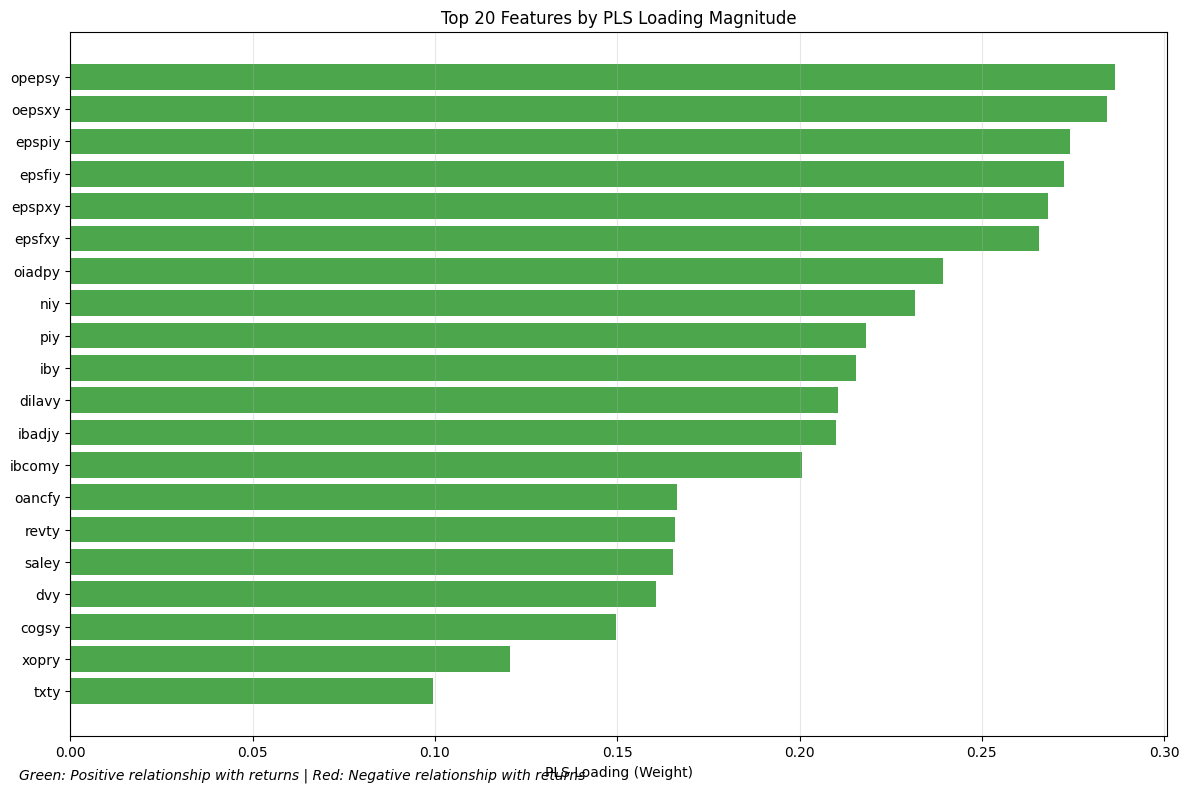

PLS SCORES ANALYSIS:
-------------------------
Number of predictions: 1000
Score statistics:
  Mean: -0.0032
  Std: 3.6636
  Min: -6.7906
  Max: 7.2273
  25th percentile: -3.3039
  75th percentile: 3.2641
Overall correlation between PLS index and returns: 0.0374


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def inspect_pls_model(pls_model, feature_names=None, top_n=20):
    """
    Comprehensive inspection of a fitted PLS model.
    
    Parameters:
    -----------
    pls_model : PLSRegression
        Fitted PLS model
    feature_names : list, optional
        Names of features used in training
    top_n : int, default=20
        Number of top features to display
    """
    
    print("=" * 60)
    print("PLS MODEL INSPECTION")
    print("=" * 60)
    
    # 1. Basic model information
    print(f"Number of components: {pls_model.n_components}")
    print(f"Number of features: {pls_model.n_features_in_}")
    
    if hasattr(pls_model, 'feature_names_in_'):
        feature_names = pls_model.feature_names_in_
        print(f"Feature names available: Yes ({len(feature_names)} features)")
    else:
        print("Feature names available: No")
        if feature_names is None:
            feature_names = [f"Feature_{i}" for i in range(pls_model.n_features_in_)]
    
    print()
    
    # 2. Component loadings (weights) - these show how much each feature contributes
    print("FEATURE LOADINGS (X-weights):")
    print("-" * 40)
    
    # X loadings for first component
    x_loadings = pls_model.x_weights_[:, 0]  # First component
    
    # Create DataFrame for easier inspection
    loadings_df = pd.DataFrame({
        'feature': feature_names,
        'loading': x_loadings,
        'abs_loading': np.abs(x_loadings)
    }).sort_values('abs_loading', ascending=False)
    
    print(f"Top {top_n} most important features:")
    print(loadings_df.head(top_n).to_string(index=False))
    print()
    
    # 3. Explained variance
    if hasattr(pls_model, 'x_scores_') and hasattr(pls_model, 'y_scores_'):
        # Calculate explained variance for X
        x_var_explained = np.var(pls_model.x_scores_[:, 0]) / np.sum(np.var(pls_model.x_scores_, axis=0)) * 100
        print(f"Variance explained in X by first component: {x_var_explained:.2f}%")
        
        # Calculate explained variance for Y  
        y_var_explained = np.var(pls_model.y_scores_[:, 0]) / np.sum(np.var(pls_model.y_scores_, axis=0)) * 100
        print(f"Variance explained in Y by first component: {y_var_explained:.2f}%")
        print()
    
    # 4. Summary statistics of loadings
    print("LOADING STATISTICS:")
    print("-" * 20)
    print(f"Mean absolute loading: {np.mean(np.abs(x_loadings)):.4f}")
    print(f"Std of loadings: {np.std(x_loadings):.4f}")
    print(f"Max loading: {np.max(x_loadings):.4f}")
    print(f"Min loading: {np.min(x_loadings):.4f}")
    print()
    
    # 5. Features with highest positive and negative loadings
    print("DIRECTIONAL IMPORTANCE:")
    print("-" * 25)
    print(f"Top {min(10, top_n//2)} features with POSITIVE loadings (increase returns):")
    positive_features = loadings_df[loadings_df['loading'] > 0].head(min(10, top_n//2))
    for _, row in positive_features.iterrows():
        print(f"  {row['feature']}: {row['loading']:.4f}")
    
    print(f"\nTop {min(10, top_n//2)} features with NEGATIVE loadings (decrease returns):")
    negative_features = loadings_df[loadings_df['loading'] < 0].head(min(10, top_n//2))
    for _, row in negative_features.iterrows():
        print(f"  {row['feature']}: {row['loading']:.4f}")
    
    return loadings_df

def plot_pls_loadings(loadings_df, top_n=20, figsize=(12, 8)):
    """
    Plot the PLS loadings for visualization.
    
    Parameters:
    -----------
    loadings_df : pd.DataFrame
        DataFrame with feature loadings from inspect_pls_model
    top_n : int, default=20
        Number of top features to plot
    figsize : tuple, default=(12, 8)
        Figure size for the plot
    """
    
    # Plot top features by absolute loading
    plt.figure(figsize=figsize)
    
    # Get top features
    top_features = loadings_df.head(top_n).copy()
    
    # Create color map (positive = green, negative = red)
    colors = ['green' if x > 0 else 'red' for x in top_features['loading']]
    
    # Create horizontal bar plot
    plt.barh(range(len(top_features)), top_features['loading'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('PLS Loading (Weight)')
    plt.title(f'Top {top_n} Features by PLS Loading Magnitude')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add grid for easier reading
    plt.grid(axis='x', alpha=0.3)
    
    # Invert y-axis so highest absolute loading is at top
    plt.gca().invert_yaxis()
    
    # Add text explanation
    plt.figtext(0.02, 0.02, 'Green: Positive relationship with returns | Red: Negative relationship with returns', 
                fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.show()

def analyze_pls_predictions(pls_model, X_test, y_test=None):
    """
    Analyze PLS model predictions and scores.
    
    Parameters:
    -----------
    pls_model : PLSRegression
        Fitted PLS model
    X_test : pd.DataFrame or np.array
        Test features
    y_test : array-like, optional
        Test targets for comparison
    """
    
    # Get PLS scores (the index values)
    pls_scores = pls_model.transform(X_test)[:, 0]
    
    print("PLS SCORES ANALYSIS:")
    print("-" * 25)
    print(f"Number of predictions: {len(pls_scores)}")
    print(f"Score statistics:")
    print(f"  Mean: {np.mean(pls_scores):.4f}")
    print(f"  Std: {np.std(pls_scores):.4f}")
    print(f"  Min: {np.min(pls_scores):.4f}")
    print(f"  Max: {np.max(pls_scores):.4f}")
    print(f"  25th percentile: {np.percentile(pls_scores, 25):.4f}")
    print(f"  75th percentile: {np.percentile(pls_scores, 75):.4f}")
    
    if y_test is not None:
        # Calculate correlation with actual returns
        correlation = np.corrcoef(pls_scores, y_test)[0, 1]
        print(f"\nCorrelation with actual returns: {correlation:.4f}")
    
    return pls_scores

# Example usage after running your PLS code:

# Inspect the model
loadings_df = inspect_pls_model(pls_model, top_n=25)

# Plot the loadings
plot_pls_loadings(loadings_df, top_n=20)

# Analyze a subset of predictions
sample_data = merged.head(1000)  # Sample for analysis
X_sample = sample_data.drop(columns=['PERMNO', 'date', 'gvkey'])
X_sample_processed = process_chunk(X_sample.dropna())  # Process the same way
pls_scores = analyze_pls_predictions(pls_model, X_sample_processed)

# Look at the relationship between PLS index and returns
merged_analysis = index_df.merge(returns, on=['date', 'gvkey'])
correlation = merged_analysis['pls_index'].corr(merged_analysis['MonthlyRet'])
print(f"Overall correlation between PLS index and returns: {correlation:.4f}")


In [18]:
index_df.to_csv('Predictors/FirmCharacIndex.csv')